# Propagation effects

In this notebook we will have a look at the individuel propagation effects that can be included.

## Setup

In [1]:
from auraliser import Auraliser, mono
from auraliser.generator import Sine, NoiseBands
import numpy as np
from geometry import Point
from IPython.display import Audio
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
%matplotlib inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from acoustics.signal import OctaveBand

In [2]:
fs = 24000.0      # Sample frequency
duration = 30.      # Duration in seconds
df = 50.0           # Frequency resolution (impedances reflections)

dt = 1.0/fs                             # Seconds per sample
t = np.arange(0.0, duration, dt)        # Time vector

model = Auraliser(duration=duration, sample_frequency=fs)

We will need a source

In [3]:
velocity = 80.0
x = np.ones_like(t) * velocity * (t - duration/2.0)    # Source moves along the x-axis.
y = np.ones_like(t) * 0.01
z = np.ones_like(t) * 80.0   # Altitude of source
src = model.add_source(name='source', position=np.vstack((x,y,z)).T)
#src = model.add_source(name='source', position=Point(0.0,0.0,0.0))
subsrc = src.add_subsource(name='subsource')

and a receiver.

In [4]:
rcv = model.add_receiver(name='receiver', position=Point(100.0,0.0,0.0))

sine = subsrc.add_virtualsource('sine')
sine.signal = Sine(frequency=100.0)
noise = subsrc.add_virtualsource('whiteband')
noise.signal = NoiseBands(bands=OctaveBand(center=1000.0))

Because we would like to consider the propagation effects individually we turn them all of for now.

In [5]:
model.settings['spreading']['include'] = False
model.settings['doppler']['include'] = False
model.settings['atmospheric_absorption']['include'] = False
model.settings['reflections']['include'] = False
model.settings['turbulence']['include'] = False

## Effects

Now that we have a basic model to work with we look at the propagation effects one by one.

### Distance reduction

In the far field sound spreads out spherically. This results in a decrease in amplitude with increase in distance.

In [6]:
model.settings['spreading']['include'] = True
signal = mono( rcv.auralise() )
model.settings['spreading']['include'] = False

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source source
/home/freddy/Data/Data/Code/auraliser/auraliser/generator.py:181: UserWarning: Cornerfrequency was higher than sample rate. Frequency band was not included.
  warnings.warn("Cornerfrequency was higher than sample rate. Frequency band was not included.")
INFO:root:Auralising mirror
INFO:root:Applying spherical spreading.
INFO:root:Finished auralising source source


In [7]:
Audio(data=signal, rate=fs)

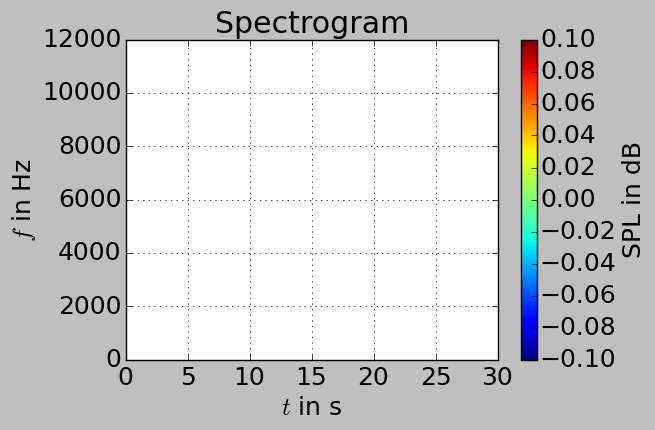

In [8]:
fig = signal.spectrogram()

### Time delay

Sound has a limited velocity resulting in a delay between emission and receivement. Movement of source and/or receiver can result in a variable time delay.

Besides the obvious time delay this also results in a Doppler shift in frequency.

In [9]:
model.settings['doppler']['include'] = True
signal = mono( rcv.auralise() )
model.settings['doppler']['include'] = False

INFO:root:Auralising at receiver
INFO:root:Can auralise.
INFO:root:Auralising source source
/home/freddy/Data/Data/Code/auraliser/auraliser/generator.py:181: UserWarning: Cornerfrequency was higher than sample rate. Frequency band was not included.
  warnings.warn("Cornerfrequency was higher than sample rate. Frequency band was not included.")
INFO:root:Auralising mirror
INFO:root:Applying Doppler frequency shift.
INFO:root:Finished auralising source source


In [10]:
Audio(data=signal, rate=fs)

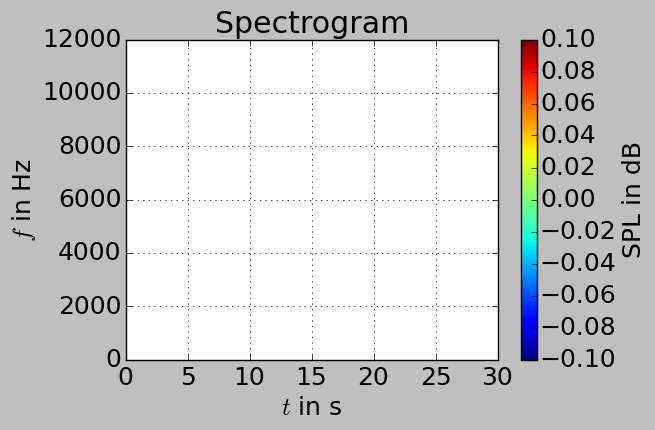

In [11]:
fig = signal.spectrogram()

In [12]:
fig = signal.plot_fractional_octaves(fraction=12)

ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

### Atmospheric absorption

Relaxation effects in the atmosphere result in additional attenuatation. 

In [ ]:
model.settings['atmospheric_absorption']['include'] = True
signal = mono( rcv.auralise() )
model.settings['atmospheric_absorption']['include'] = False

In [ ]:
Audio(data=signal, rate=fs)

In [ ]:
fig = signal.spectrogram()

In [ ]:
fig = signal.plot_third_octaves(fraction=12)

In [ ]:
fig = signal.plot_levels()